**Word-level Attention model**

---

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import string

from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, TimeDistributed, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model 
from attention import BahdanauAttention
# from gensim.models import Word2Vec, KeyedVectors
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from google.colab import drive
from string import punctuation

In [ ]:
!!curl -O http://www.manythings.org/anki/ita-eng.zip
!!unzip ita-eng.zip

drive.mount('/content/drive')

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LSTM_NODES = 256
NUMBER_SENTENCES = 20000
EMBEDDING_SIZE = 100
NUMBER_SENTENCES_TEST = 2000

In [ ]:
input_sentences = [] # All original English sentences
output_sentences = [] # All actual target Italian sentences with an end-of-sentences token
input_sentences_test = []
output_sentences_test = []

count_rows = 1
with open(os.path.join('ita.txt'), 'r', encoding='utf-8') as f:
    while count_rows <= (NUMBER_SENTENCES + NUMBER_SENTENCES_TEST):
        row = f.readline().rstrip().split("\t")
        if count_rows <= NUMBER_SENTENCES:
            input_sentences.append(row[0])
            output_sentences.append("<sos> " + row[1] + " <eos>")
        else:
            input_sentences_test.append(row[0])
            output_sentences_test.append(row[1])

        count_rows += 1

In [ ]:
# print("num_samples_input: ", len(input_sentences))
# print("num_samples_output: ", len(output_sentences))
# print("num_samples_output_input: ", len(output_sentences_inputs))
# print("num_samples_input_test: ", len(input_sentences_test))
# print("num_samples_output_test: ", len(output_sentences_test))
# print(input_sentences[19999])
# print(output_sentences[19999])
# print(output_sentences_inputs[19999])
# print(input_sentences_test[0])
# print(output_sentences_test[0])

In [ ]:
# Make all words lowercase
input_sentences = [x.lower() for x in input_sentences]
output_sentences = [x.lower() for x in output_sentences]
input_sentences_test = [x.lower() for x in input_sentences_test]
output_sentences_test = [x.lower() for x in output_sentences_test]

# Exclude all punctuation, that is !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
exclude = set(string.punctuation)
input_sentences = [''.join(ch for ch in x if ch not in exclude) for x in input_sentences]
output_sentences = [''.join(ch for ch in x if ch not in exclude) for x in output_sentences]
input_sentences_test = [''.join(ch for ch in x if ch not in exclude) for x in input_sentences_test]
output_sentences_test = [''.join(ch for ch in x if ch not in exclude) for x in output_sentences_test]

In [ ]:
# print(input_sentences[19999])
# print(output_sentences[19999])
# print(output_sentences_inputs[19999])
# print(input_sentences_test[0])
# print(output_sentences_test[0])

In [ ]:
input_tokens = set()
target_tokens = set()

for input in input_sentences:
    for word in input.split():
        if word not in input_tokens:
            input_tokens.add(word)

for target in output_sentences:
    for word in target.split():
        if word not in target_tokens:
            target_tokens.add(word)

# Add UNK token, in order to recognize unknown words we encountered
input_tokens.add("unk")
target_tokens.add("unk")    

input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input)) for input in input_sentences]) # The maximum length is computed by the words point of view
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target)) for target in output_sentences]) # The maximum length is computed by the words point of view

input_token_index = dict([(word, index) for index, word in enumerate(input_tokens)]) # Vocabulary of words for English sentences
target_token_index = dict([(word, index) for index, word in enumerate(target_tokens)]) # Vocabulary of words for Italian sentences

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_word_index = dict((index, word) for word, index in input_token_index.items())
reverse_target_word_index = dict((index, word) for word, index in target_token_index.items())

In [ ]:
# print(input_tokens)
# print(target_tokens)
# print(max_encoder_seq_length)
# print(max_decoder_seq_length)
# print(input_token_index)
# print(target_token_index)
# print(reverse_input_word_index)
# print(reverse_target_word_index)

In [ ]:
encoder_input_data = np.zeros((len(input_sentences), max_encoder_seq_length), dtype='float32')
decoder_input_data = np.zeros((len(output_sentences), max_decoder_seq_length), dtype='float32')
decoder_target_data = np.zeros((len(output_sentences), max_decoder_seq_length, num_decoder_tokens), dtype='float32') # One-hot encoding

for i, (input_text, target_text) in enumerate(zip(input_sentences, output_sentences)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the <sos> start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [ ]:
# print(encoder_input_data[0])
# print(decoder_input_data[0])
# print(decoder_target_data[0])

# print(input_token_index["unk"])
# print(target_token_index["unk"])
# print(target_token_index["sos"])
# print(target_token_index["eos"])

In [ ]:
# For test
test_sentences_data = np.zeros((NUMBER_SENTENCES_TEST, max_encoder_seq_length), dtype='float32')

for i, test_text in enumerate(input_sentences_test):
    for t, word in enumerate(test_text):
        try:
            test_sentences_data[i, t] = input_token_index[word]
        except:
            if t < max_encoder_seq_length:
                test_sentences_data[i, t] = input_token_index["unk"]
            else:
                break

Here we add  part about Word Embedding.

We need to represent a word (that now is an integer) in a vector representation of whatever dimension. Indeed, word embeddings capture more info about words, for example it is able to understand the relationship between two words (how much are similar). We use Skip-gram Word2Vec for input word embeddings, whereas one-hot encoding for the output ones.

In [ ]:
# Target: offer to Word2Vec method a list of list of strings (as requested)
# Ex. [[look at the dictionary], [hi mate]] --> [[look, at, the, dictionary], [hi, mate]]
# tokenized_input_sentences = []
# count_rows = 0
# while count_rows < NUMBER_SENTENCES:
#     sentence = encoder_input_data[count_rows]
#     new_sentence = [None] * len(sentence)
#     for it in range(len(sentence)):
#         idx = sentence[it]
#         word = reverse_input_word_index[idx]
#         new_sentence[it] = word

#     tokenized_input_sentences.append(new_sentence)
#     count_rows += 1

# word2vec_model = Word2Vec(tokenized_input_sentences, size=EMBEDDING_SIZE, min_count=1, workers=4, window=5, sg=1)

# embedding_matrix = np.zeros((num_encoder_tokens, EMBEDDING_SIZE)) # It will be used to create the embedding layer for LSTM units in the attention model
# for index in range(embedding_matrix.shape[0]):
#     word = reverse_input_word_index[index]
#     try:
#         embedding_matrix[index] = word2vec_model.wv[word]
#     except KeyError:
#         continue

In [ ]:
# Summarize vocabulary
# words = list(word2vec_model.wv.index_to_key)
# print(words)
# Access vector for one word
# print(word2vec_model.wv['trump'])

# word2vec_model.save("Backup_Models/Word_Embeddings/Word2Vec_Embeddings.kv")
# word2vec_model = KeyedVectors.load("Backup_Models/Word_Embeddings/Word2Vec_Embeddings.kv", mmap='r')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 5, 100)       227900      ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 9, 256)       1461504     ['input_6[0][0]']                
                                                                                            

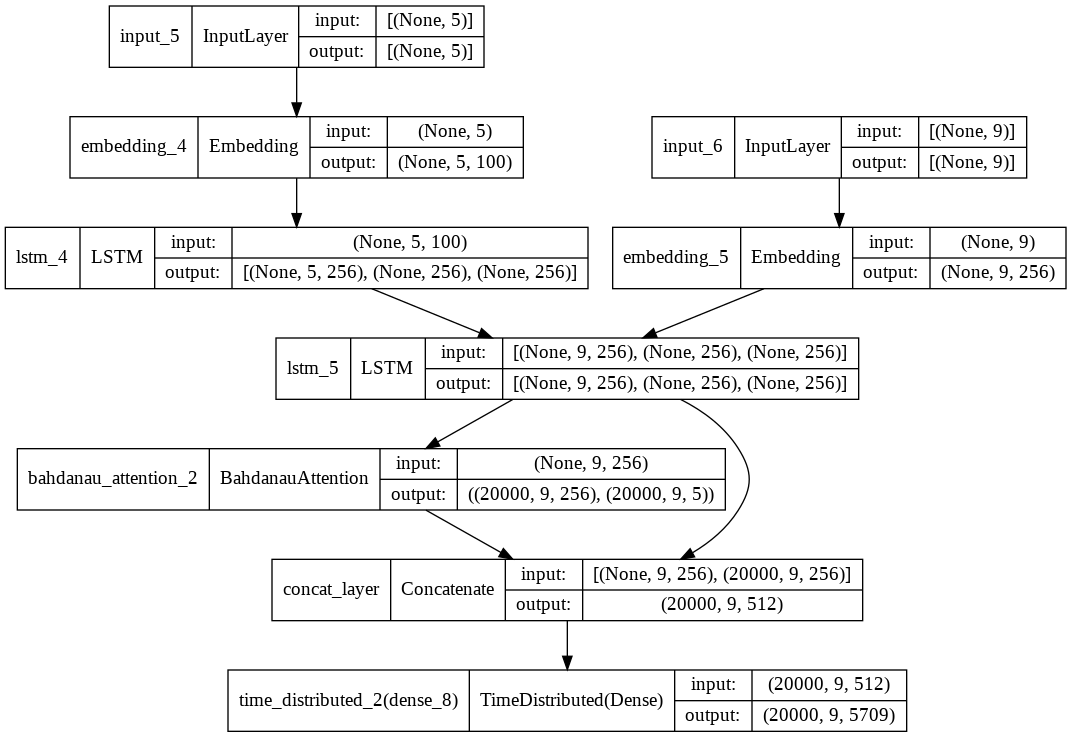

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_encoder_seq_length,))
# encoder_embedding_layer = Embedding(num_encoder_tokens, EMBEDDING_SIZE, weights=[embedding_matrix], mask_zero=True, trainable=False) # Apply this row if you used the pre-defined word embeddings (two code blocks above)
encoder_embedding_layer = Embedding(num_encoder_tokens, EMBEDDING_SIZE, trainable=True)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)
encoder_lstm_layer = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm_layer(encoder_embeddings)
encoder_states = [state_hidden, state_cell]

# Decoder
decoder_inputs = Input(shape=(max_decoder_seq_length,))
decoder_embedding_layer = Embedding(num_decoder_tokens, LSTM_NODES, trainable=True)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)
decoder_lstm_layer = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_states)

# Set up the attention layer
attention_layer = BahdanauAttention(LSTM_NODES)
attention_output, attention_states = attention_layer(
              query=decoder_outputs,
              value=encoder_outputs,
              mask=(encoder_input_data != 0))
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attention_output])

decoder_dense_layer = TimeDistributed(Dense(num_decoder_tokens, activation="softmax")) # TimeDistributed layer is applied because decoder_outputs is used combined with attention_output at every input temporal slice
decoder_outputs = decoder_dense_layer(decoder_concat_input)

# Compile the model
attention_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
attention_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]) 

attention_model.summary()
plot_model(attention_model, to_file="training_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), # If the validation loss value does not improve within 15 epochs, stop the training
    ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Word_Level_Attention_Model.h5", save_best_only=True) # Change path if you run this code in another location     
]

# Train the model
history = attention_model.fit(
    [encoder_input_data, decoder_input_data], 
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[callbacks]
)

In [ ]:
# Save the model
# attention_model.save("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Saved_Models/Word_Level_Attention_Model.h5") 

In [ ]:
# Load the model
# attention_model = load_model("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Saved_Models/Word_Level_Attention_Model.h5")

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['accuracy'], label='training accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.title('Accuracy trend')
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch,history.history['loss'], label='training loss')
    plt.plot(history.epoch,history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Loss trend')
    plt.grid(True)
    plt.show()

plot_accuracy(history)
print("\n")
plot_loss(history)

Inference model (TO MODIFY)

In [ ]:
# Set up the encoder
encoder_inputs = attention_model.input[0]
encoder_outputs, state_hidden_enc, state_cell_enc = attention_model.layers[4].output
encoder_states = [state_hidden_enc, state_cell_enc]
encoder_test_model = Model(encoder_inputs, encoder_states)

# Set up the decoder
decoder_inputs_single = attention_model.input[1] # At each time step, only single word in the decoder input
decoder_state_input_hidden = Input(shape=(LSTM_NODES,))
decoder_state_input_cell = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_embedding_layer = attention_model.layers[3]
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
decoder_lstm_layer = attention_model.layers[5]
decoder_partial_outputs, state_hidden_dec, state_cell_dec = decoder_lstm_layer(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_hidden_dec, state_cell_dec]
decoder_dense_layer = attention_model.layers[6]
decoder_outputs = decoder_dense_layer(decoder_partial_outputs)
decoder_test_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
encoder_test_model.summary()
plot_model(encoder_test_model, to_file="encoder_test_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
decoder_test_model.summary()
plot_model(decoder_test_model, to_file="decoder_test_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
def decode_sequence(input_sequence):
    # Encode the input as state vectors.
    states_value = encoder_test_model.predict(input_sequence)
    # Generate empty target sequence of length 1.
    target_sequence = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_sequence[0, 0] = target_token_index["sos"]

    # Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
    stop_condition = False
    output_sentence = []
    while not stop_condition:
        output_tokens, state_hidden, state_cell = decoder_test_model.predict([target_sequence] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]

        # Exit condition: either hit max length or find stop character.
        if sampled_word == "eos" or len(output_sentence) > max_decoder_seq_length:
            stop_condition = True
        else:
            output_sentence.append(sampled_word)

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            states_value = [state_hidden, state_cell]

    return output_sentence

In [ ]:
input_sentences_splitted = [] # A list containing all the input sentences splitted, as requested for the BLEU computation
predicted_sentences_splitted = [] # A list containing all the translated sentences splitted, as requested for the BLEU computation

for index in range(NUMBER_SENTENCES_TEST):
    input_sequence = test_sentences_data[index : index + 1]
    predicted_sentence = decode_sequence(input_sequence)

    input_sentences_splitted.append([input_sentences_test[index].split()])
    predicted_sentences_splitted.append(" ".join(predicted_sentence).split())

In [ ]:
predicted_sentences = [] # A list containing all the translated sentences

for index in range(len(predicted_sentences_splitted)):
    predicted_sentences.append(" ".join(predicted_sentences_splitted[index]))

for index in range(NUMBER_SENTENCES_TEST):
    print("Sentence n.", index)
    print("-")
    print("Input sentence:", input_sentences_test[index])
    print("Target sentence:", output_sentences_test[index])
    print("Decoded sentence:", predicted_sentences[index])
    print("\n")

In [ ]:
# Save predictions in a file
predictions_text = open(os.path.join('Predictions_Word_Level_Attention.txt'), 'x', encoding='utf-8')
for sentence in predicted_sentences_splitted:
    predictions_text.write(str(sentence) + "\n")

# Load prediction from the file
# predicted_sentences = []
# with open(os.path.join('Predictions_Word_Level_Attention.txt'), 'r', encoding='utf-8') as f:
#     predicted_sentences.append(" ".join(f.readline().rstrip()))

In [ ]:
def compute_bleu_score(input_sentences, predicted_sentences):
    bleu_scores = {}

    bleu_scores['1-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(1.0, 0, 0, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['2-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['3-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.3, 0.3, 0.3, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['4-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method7)

    return bleu_scores

# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_scores_test = compute_bleu_score(input_sentences_splitted, predicted_sentences_splitted)

In [ ]:
print(bleu_scores_test)

In [ ]:
plt.bar(x = bleu_scores_test.keys(), height = bleu_scores_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()